# Projeto Spark

Entrega: 31 de maio de 2023

## Introdução

Neste projeto vamos construir um classificador Naive-Bayes para determinar o sentimento de um comentário.

## Grupos

O projeto pode ser individual ou em duplas. Criem os grupos em https://classroom.github.com/a/EdbpYF9x

## Instalando o ambiente

O jeito mais simples de começar a trabalhar com Spark é instalar um container com tudo pronto! No site https://hub.docker.com/r/jupyter/pyspark-notebook vemos uma imagem Docker que já vem com `pyspark` e `jupyter lab`. Instale a imagem com o comando:

```bash
docker pull jupyter/pyspark-notebook
```

Vamos iniciar o ambiente de trabalho com o comando `docker run`. Para isso precisamos tomar alguns cuidados:

1) Temos que mapear nosso diretorio local de trabalho para um diretório interno do container, de modo que alterações feitas dentro do container (nesta pasta escolhida) sejam gravadas no nosso diretorio local. No container temos um usuário padrão com *username* `jovyan`. No *homedir* desse usuario temos uma pasta vazia `work`, que vai servir como local de mapeamento do nosso diretorio local de trabalho. Podemos então fazer esse mapeamendo com a opção `-v` do comando `docker run` da seguinte forma:

```bash
-v <diretorio>:/home/jovyan/work
```

onde `<diretorio>` representa seu diretorio local de trabalho.

2) Para acessar o `jupyter notebook` e o *dashboard* do Spark a partir do nosso *browser* favorito temos que abrir algumas portas do container com a opção `-p`. As portas são `8888` (para o próprio `jupyter notebook`) e `4040` (para o *dashboard* do Spark). Ou seja, adicionaremos às opções do `docker run`o seguinte:

```bash
-p 8888:8888 -p 4040:4040
```

Desta forma, ao acessar `localhost:8888` na nossa máquina, estaremos acessando o servidor Jupyter na porta 8888 interna do container.

3) Vamos iniciar o container no modo interativo, e vamos especificar que o container deve ser encerrado ao fechar o servidor Jupyter. Faremos isso com as opções `-it` e `-rm`

Portanto, o comando completo que eu uso na minha máquina Linux para iniciar o container é:

```bash
docker run \
    -it \
    --rm \
    -p 8888:8888 \
    -p 4040:4040 \
    -v "`pwd`":/home/jovyan/work \
    jupyter/pyspark-notebook
```

Para facilitar a vida eu coloco esse comando em um arquivo `inicia.sh`. Engenheiros, façam do jeito que preferirem!

Agora abra esse notebook lá no container!


## Iniciando o Spark

Vamos iniciar o ambiente Spark. Para isso vamos:

1) Criar um objeto de configuração do ambiente Spark. Nossa configuração será simples: vamos especificar que o nome da nossa aplicação Spark é "Minha aplicação", e que o *master node* é a máquina local, usando todos os *cores* disponíveis. Aplicações reais de Spark são configuradas de modo ligeiramente diferente: ao especificar o *master node* passamos uma URL real, com o endereço do nó gerente do *cluster* Spark.

2) Vamos criar um objeto do tipo `SparkContext` com essa configuração

In [2]:
import pyspark

conf = pyspark.SparkConf()
conf.setAppName('Minha aplicação')
conf.setMaster('local[*]')

sc = pyspark.SparkContext(conf=conf)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=Minha aplicação, master=local[*]) created by __init__ at /tmp/ipykernel_130/380438692.py:7 

O `SparkContext` é a nossa porta de entrada para o cluster Spark, ele será a raiz de todas as nossas operações com o Spark.

In [16]:
sc

<SparkContext master=local[*] appName=Minha aplicação>

O link acima provavelmente não funcionará porque ele se refere à porta 4040 interna do container (portanto a URL está com endereço interno). Porém fizemos o mapeamento da porta 4040 interna para a porta 4040 externa, logo você pode acessar o *dashboard* do Spark no endereço http://localhost:4040

<center><img src="./spark_dashboard.png" width=800/></center>

## Lendo os dados

Vamos começar lendo o arquivo de reviews e gravando o resultado em formato pickle, mais amigável.

In [6]:
def parse_line(line):
    parts = line[1:-1].split('","')
    sentiment = int(parts[0])
    title = parts[1].replace('""', '"')
    body = parts[2].replace('""', '"')
    return (sentiment, title, body)

rdd = sc.textFile('train.csv').map(parse_line)

In [7]:
rdd.count()

3600000

In [8]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora vamos gravar no formato pickle, para facilitar os trabalhos futuros. Após gravar o arquivo, não mais rode as células desta primeira etapa!

In [9]:
rdd.saveAsPickleFile('reviews.pickle')

## Um classificador Naive-Bayes

Vamos ler o arquivo pickle gravado anteriormente:

In [3]:
rdd = sc.pickleFile('reviews.pickle')

In [4]:
rdd.count()

3600000

In [5]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora, complete as tarefas em sequencia para construir o classificador Naive-Bayes:

### Fase 1

#### Tarefa

Construa uma função que recebe um RDD no formato do RDD original e retorna um RDD no qual cada item é um par (palavra, contagem).

In [6]:
import re
import math

token_regex = r'(?u)\b\w\w+\b'

def palavra_count(rdd):
    """
    Usa regex para tokenizar o texto, assim remove caracteres especiais.
    """
    rdd_tokens = rdd \
                 .flatMap(lambda x: re.findall(token_regex, (x[1] + " " + x[2]).lower())) \
                 .map(lambda x: (x, 1)) \
                 .reduceByKey(lambda x, y: x + y)
    return rdd_tokens

In [7]:
rdd_counts = palavra_count(rdd)

In [8]:
rdd_counts.take(20)

[('out', 834488),
 ('like', 1034037),
 ('jaw', 1834),
 ('book', 1972759),
 ('family', 96186),
 ('let', 106826),
 ('belief', 5929),
 ('wasting', 9086),
 ('spelling', 4229),
 ('item', 127426),
 ('immediate', 2627),
 ('timbre', 283),
 ('24', 14325),
 ('start', 86001),
 ('came', 126740),
 ('combo', 5745),
 ('titled', 7848),
 ('willing', 11447),
 ('kinda', 13756),
 ('boorish', 212)]

#### Tarefa

Construa uma função que recebe o RDD (palavra, contagem) construido anteriormente e retorna um RDD no qual cada item é um par (palavra, $\log_{10}\left(c \, / \, T\right)$), onde $c$ é a contagem daquela palavra e $T$ é a soma das contagens de palavra.

In [9]:
T = rdd_counts.map(lambda x: x[1]).sum()
T

269303658

In [10]:
def log_count(rdd, T):
    return rdd.map(lambda x: (x[0], math.log((x[1] / T), 10)))

In [11]:
rdd_log = log_count(rdd_counts, T)
rdd_log.take(20)

[('out', -2.5088221566786366),
 ('like', -2.415706173553501),
 ('jaw', -5.166842921217594),
 ('book', -2.1351682191813217),
 ('family', -3.4471303880523507),
 ('let', -3.4015652856053142),
 ('belief', -4.657260802206633),
 ('wasting', -4.471869520072989),
 ('spelling', -4.804004567404696),
 ('item', -3.324984202068149),
 ('immediate', -5.010782179765526),
 ('timbre', -5.978455817027306),
 ('24', -4.274147621912169),
 ('start', -3.4957387514015523),
 ('came', -3.3273285497623757),
 ('combo', -4.670952219527293),
 ('titled', -4.535483258179704),
 ('willing', -4.371550569732366),
 ('kinda', -4.291750085401621),
 ('boorish', -6.1039063916228455)]

#### Tarefa

Separe o RDD original em dois RDDs: o dos reviews positivos e o dos negativos. Em seguida, use as funções anteriores para construir RDDs que contem os pares (palavra, $\log_{10}\left(c \, / \, T\right)$)

In [12]:
positivos = rdd.filter(lambda x: x[0] == 2)
negativos = rdd.filter(lambda x: x[0] == 1)
# Mapeia o rdd para ('palavra', contagem).
count_neg = palavra_count(negativos)
count_pos = palavra_count(positivos)
# Contagem de palavras Positivo e negativo
T_pos = count_pos.map(lambda x: x[1]).sum()
T_neg = count_neg.map(lambda x: x[1]).sum()
print(T_pos, T_neg)
# Mapeia para probabilidade em log.
log_pos = log_count(count_pos, T_pos)
log_neg = log_count(count_neg, T_neg)   
log_neg.take(4)

129576085 139727573


[('book', -2.167071916072983),
 ('family', -3.7149651357537117),
 ('belief', -4.605829624086224),
 ('wasting', -4.2425179717115995)]

In [13]:
log_pos.take(4)

[('out', -2.541106036840971),
 ('like', -2.424804203519201),
 ('jaw', -5.1077736984827125),
 ('book', -2.1032040111229082)]

### Tarefa

Use o `.fullOuterJoin()` dos RDDs para construir um RDD unificado, no qual cada item é da forma (palavra, log_prob_positivo, log_prob_negativo). "Baixe" esse resultado final usando `.collect()`.

In [14]:
# (Negativo, positivo)!
full_out_join = log_neg.fullOuterJoin(log_pos)
full_out_join.take(10)

[('family', (-3.7149651357537117, -3.272098804982048)),
 ('belief', (-4.605829624086224, -4.720531781814001)),
 ('out', (-2.4808874387193827, -2.541106036840971)),
 ('timbre', (-6.176799167081749, -5.833771253120885)),
 ('24', (-4.23460436089298, -4.321255373163445)),
 ('kinda', (-4.295064873837296, -4.288203729222943)),
 ('flour', (-5.019475657496158, -5.0934085636266415)),
 ('ed', (-4.644496942718229, -4.606696820218878)),
 ('returns', (-4.492649047552574, -4.702591730742419)),
 ('narrative', (-4.451731030039772, -4.415993734104107))]

In [15]:
resultado_collected = full_out_join.collect()

#### Tarefa

Para uma dada string, determine se ela é um review positivo ou negativo usando os RDDs acima. Lembre-se de como funciona o classificador Naive-Bayes: http://stanford.edu/~jurafsky/slp3/slides/7_NB.pdf, consulte tambem suas notas de aula de Ciência dos Dados!

In [17]:
total = T_pos + T_neg
p_pos = math.log(T_pos / total, 10)
p_neg = math.log(T_neg / total, 10)
p_pos, p_neg

(-0.17113737883293811, -0.2193252012202116)

In [18]:
def naive_bayes(string, full_rdd, p_pos, p_neg) -> int:
    """
    Retorna 1 quando negativo, 2 quando positivo.
    """
    palavras = re.findall(token_regex, string.lower())
    positividade = p_pos
    negatividade = p_neg
    rdd_palavras = full_rdd.filter(lambda x: x[0] in palavras)
    dict_rdd = rdd_palavras.collectAsMap()
    # print(dict_rdd)
    for palavra in palavras:
        if palavra not in dict_rdd:
            continue
        log_p_neg, log_p_pos = dict_rdd[palavra]
        if log_p_neg != None:
            negatividade += log_p_neg
        if log_p_pos != None: 
            positividade += log_p_pos
    return 1 if negatividade > positividade else 2

naive_bayes("Really good product!", full_out_join, p_pos, p_neg)

2

### Fase 2

Agora que temos um classificador Naive-Bayes, vamos explorá-lo um pouco:

### Tarefa

Quais são as 100 palavras que mais indicam negatividade, ou seja, onde a diferença entre a probabilidade da palavra no conjunto dos comentários negativos e positivos é máxima? E quais as 100 palavras de maior positividade? Mostre os resultados na forma de *word clouds*.

In [19]:
def conta_negatividade(x):
    p_neg, p_pos = x[1]
    if p_neg is None or p_pos is None:
        return (x[0], 0)
    return (x[0], p_neg - p_pos)
    

In [20]:
mais_neg = full_out_join \
    .map(conta_negatividade) \
    .takeOrdered(100, lambda x: -x[1])

mais_pos = full_out_join \
    .map(conta_negatividade) \
    .takeOrdered(100, lambda x: x[1])

In [21]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 10.7 MB/s eta 0:00:0000:01


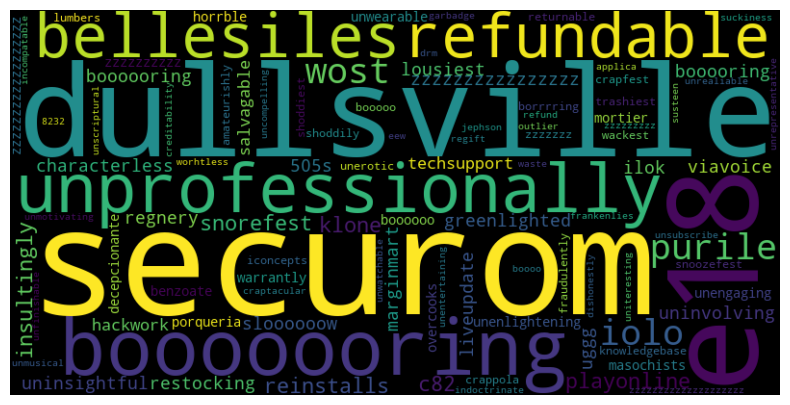

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_neg = WordCloud(width=800, height=400)
wordcloud_neg.generate_from_frequencies(dict(mais_neg))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.show()

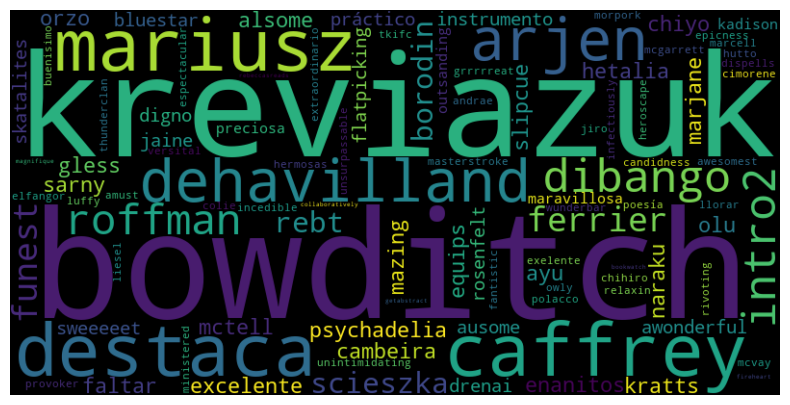

In [23]:
wordcloud_pos = WordCloud(width=800, height=400)
wordcloud_pos.generate_from_frequencies(dict(mais_pos))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.show()

### Tarefa desafio!

Qual o desempenho do classificador (acurácia)? Para medir sua acurácia:

- Separe os reviews em dois conjuntos: treinamente e teste
- Repita o "treinamento" do classificador com o conjunto de treinamento
- Para cada review do conjunto de teste, determine se é positiva ou negativa de acordo com o classificador
- Determine a acurácia

Esta não é uma tarefa trivial. Não basta fazer um `for` para determinar a classe de cada review de teste: isso demoraria uma eternidade. Você tem que usar variáveis "broadcast" do Spark para enviar uma cópia da tabela de frequencias para cada *core* do executor.

In [24]:
# 80% treino, 20% teste
train, test = rdd.randomSplit([0.8, 0.2])

pos_train = train.filter(lambda x: x[0] == 2)
neg_train = train.filter(lambda x: x[0] == 1)

# Conta palavras
count_pos_train = palavra_count(pos_train)
count_neg_train = palavra_count(neg_train)

T_pos = count_pos_train.map(lambda x: x[1]).sum()
T_neg = count_neg_train.map(lambda x: x[1]).sum()
print(T_pos, T_neg, T_pos + T_neg)

# Transforma para log.
log_pos_train = log_count(count_pos_train, T_pos)
log_neg_train = log_count(count_neg_train, T_neg)   

# Junta os dois rdds.
full_train = log_neg_train.fullOuterJoin(log_pos_train)
full_train.take(20)

103692986 111768561 215461547


[('family', (-3.716831626743809, -3.2726474485722)),
 ('belief', (-4.601937847281898, -4.718426666633908)),
 ('out', (-2.480908601183493, -2.5404487354707364)),
 ('24', (-4.235941148350147, -4.325021836968845)),
 ('kinda', (-4.2896348096219, -4.293938765626665)),
 ('flour', (-5.016911195252717, -5.085819820754623)),
 ('ed', (-4.6385555552379945, -4.612285679493894)),
 ('returns', (-4.489251325469803, -4.70336043146862)),
 ('narrative', (-4.447237931720317, -4.412063831224511)),
 ('start', (-3.539399587642939, -3.4534922132866215)),
 ('tenon', (-6.793047154401034, -6.5843856166802235)),
 ('fusion', (-5.115338837581143, -4.750224045620137)),
 ('willing', (-4.3294859412004785, -4.4264701596032445)),
 ('gift', (-3.6940959362394903, -3.4245177695876574)),
 ('overly', (-4.351875896365342, -4.574054245198495)),
 ('lyric', (-5.3476159423593215, -5.070773472427164)),
 ('backround', (-5.650379650832304, -5.568591349496992)),
 ('meets', (-4.540194123421141, -4.265163853498203)),
 ('teaching', (-4

In [25]:
total_train = T_pos + T_neg
p_pos_train = math.log(T_pos / total_train, 10)
p_neg_train = math.log(T_neg / total_train, 10)

In [26]:
tabela_freqs = sc.broadcast(full_train.collectAsMap())

In [27]:
def naive_bayes_broadcast(string, broadcast_data, p_pos, p_neg) -> int:
    """
    Retorna 1 quando negativo, 2 quando positivo.
    """
    palavras = re.findall(token_regex, string.lower())
    positividade = p_pos
    negatividade = p_neg
    dict_probs = broadcast_data.value
    # print(dict_rdd)
    for palavra in palavras:
        if palavra not in dict_probs:
            continue
        # Trata o caso de o conjunto de Negativo ou o conjunto de Positivos nao ter a palavra
        log_p_neg, log_p_pos = dict_probs[palavra]
        if log_p_neg != None:
            negatividade += log_p_neg
        if log_p_pos != None: 
            positividade += log_p_pos
        
    return 1 if negatividade > positividade else 2    

In [28]:
def evaluate(row):
    string = row[1] + " " + row[2]
    pred = naive_bayes_broadcast(string, tabela_freqs, p_pos_train, p_neg_train)
    return pred == row[0]

res = test.map(evaluate)
true_count = res.filter(lambda x: x).count()
false_count = res.filter(lambda x: not x).count()

print(true_count, false_count)
print("ACC: ", (true_count) / (true_count + false_count))

588024 132103
ACC:  0.816555968599983


### Tarefa desafio!

Implemente Laplace smoothing

In [29]:
ALPHA = 1
# N_FEATURES vai ser o numero de palavras unicas no dataset.
N_FEATURES = full_train.count()

def calc_p_smoothed(x, T):
    prob = math.log(((x[1] + ALPHA) / (T + ALPHA * N_FEATURES)), 10)
    return (x[0], prob)

zero_prob_pos = ALPHA / (T_pos + ALPHA * N_FEATURES)
zero_prob_neg = ALPHA / (T_neg + ALPHA * N_FEATURES)

In [30]:
log_pos_train_sm = count_pos_train.map(lambda x: calc_p_smoothed(x, T_pos))
log_neg_train_sm = count_neg_train.map(lambda x: calc_p_smoothed(x, T_neg))

# Junta os dois com smooth.
full_train_sm = log_neg_train_sm.fullOuterJoin(log_pos_train_sm)
full_train_sm.take(20)

[('family', (-3.7201199838313554, -3.27620482048651)),
 ('belief', (-4.605091093044101, -4.721772931480109)),
 ('out', (-2.4842160258907384, -2.5440125002025176)),
 ('24', (-4.239182857244988, -4.328498541317353)),
 ('kinda', (-4.292867716207765, -4.2974215830833105)),
 ('flour', (-5.019815988787374, -5.088875004531568)),
 ('ed', (-4.64169513678645, -4.61567940950772)),
 ('returns', (-4.492440071112969, -4.706714160037009)),
 ('narrative', (-4.450437727502411, -4.415520895161306)),
 ('start', (-3.5426947340677124, -3.4570455324517018)),
 ('tenon', (-6.772874659164915, -6.572156567956049)),
 ('fusion', (-5.118140972269039, -4.753553682580659)),
 ('willing', (-4.332711574102883, -4.429923576161335)),
 ('gift', (-3.6973853258081957, -3.428071856714759)),
 ('overly', (-4.355097140148137, -4.577462423524977)),
 ('lyric', (-5.350060275061817, -5.073846014166449)),
 ('backround', (-5.651954538636707, -5.570608279393189)),
 ('meets', (-4.543367954605411, -4.268651953164213)),
 ('teaching', (-4

In [31]:
def naive_bayes_smooth(string, full_rdd, p_pos, p_neg) -> int:
    """
    Retorna 1 quando negativo, 2 quando positivo.
    """
    palavras = re.findall(token_regex, string.lower())
    positividade = p_pos
    negatividade = p_neg
    rdd_palavras = full_rdd.filter(lambda x: x[0] in palavras)
    dict_rdd = rdd_palavras.collectAsMap()
    for palavra in palavras:
        # Valores default: zero_prob.
        log_p_neg, log_p_pos = dict_rdd.get(palavra, (zero_prob_neg, zero_prob_pos))
        if log_p_neg is None:
            log_p_neg = zero_prob_neg
        if log_p_pos is None:
            log_p_pos = zero_prob_pos
        negatividade += log_p_neg
        positividade += log_p_pos
    return 1 if negatividade > positividade else 2

naive_bayes_smooth("Really good botheri product!", full_train_sm, p_pos_train, p_neg_train)

1

## Rubrica de avaliação

- I: groselha, falha crítica, ou não entregou nada
- D: Fez uma tentativa honesta de fazer todos os itens da fase 1, mas tem erros
- C: Fase 1 completa
- B: Fase 2, faltando apenas um desafio
- A: Fase 2 completa